## Load libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from kaggle_datasets import KaggleDatasets
import transformers
from tqdm.notebook import tqdm
from tokenizers import BertWordPieceTokenizer

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


## Helper functions

In [2]:
def clean_text(text):
    text = str(text)
    text = re.sub(r'[0-9"]', '', text) # number
    text = re.sub(r'#[\S]+\b', '', text) # hash
    text = re.sub(r'@[\S]+\b', '', text) # mention
    text = re.sub(r'https?\S+', '', text) # link
    text = re.sub(r'\s+', ' ', text) # multiple white spaces
#     text = re.sub(r'\W+', ' ', text) # non-alphanumeric
    return text.strip()

In [3]:
def text_process(text):
    ws = text.split(' ')
    if(len(ws)>160):
        text = ' '.join(ws[:160]) + ' ' + ' '.join(ws[-32:])
    return text

In [4]:
def fast_encode(texts, tokenizer, chunk_size=256, maxlen=512):
 
    tokenizer.enable_truncation(max_length=maxlen)
    tokenizer.enable_padding(max_length=maxlen)
    all_ids = []
    
    for i in tqdm(range(0, len(texts), chunk_size)):
        text_chunk = texts[i:i+chunk_size].tolist()
        encs = tokenizer.encode_batch(text_chunk)
        all_ids.extend([enc.ids for enc in encs])
    
    return np.array(all_ids)

In [5]:
# First load the real tokenizer
tokenizer = transformers.BertTokenizer.from_pretrained('bert-large-uncased')

# Save the loaded tokenizer locally
save_path = '/kaggle/working/bert_base_uncased/'
if not os.path.exists(save_path):
    os.makedirs(save_path)
tokenizer.save_pretrained(save_path)

# Reload it with the huggingface tokenizers library
fast_tokenizer = BertWordPieceTokenizer('bert_base_uncased/vocab.txt', lowercase=True)
fast_tokenizer

Tokenizer(vocabulary_size=30522, model=BertWordPiece, unk_token=[UNK], sep_token=[SEP], cls_token=[CLS], pad_token=[PAD], mask_token=[MASK], clean_text=True, handle_chinese_chars=True, strip_accents=True, lowercase=True, wordpieces_prefix=##)

## TPU config

In [6]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


In [7]:
# Configuration
AUTO = tf.data.experimental.AUTOTUNE
EPOCHS_1 = 20
EPOCHS_2 = 2
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
MAX_LEN = 192
SHUFFLE = 2048
VERBOSE = 1

## Read data

In [8]:
train1 = pd.read_csv("/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-toxic-comment-train.csv")
train2 = pd.read_csv("/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-unintended-bias-train.csv")
train2.toxic = train2.toxic.round().astype(int)

valid = pd.read_csv('/kaggle/input/val-en-df/validation_en.csv')

test1 = pd.read_csv('/kaggle/input/test-en-df/test_en.csv')
test2 = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-test-translated/jigsaw_miltilingual_test_translated.csv')

sub = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/sample_submission.csv')
sub1 = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/sample_submission.csv')
sub2 = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/sample_submission.csv')

In [9]:
# oversample====
train = pd.concat([
    train1[['comment_text', 'toxic']],
    train2[['comment_text', 'toxic']].query('toxic==1'),
    train2[['comment_text', 'toxic']].query('toxic==0').sample(n=100000, random_state=1234)
    ])
# shufle it just to make sure
train = train.sample(frac=1, random_state=1234)

In [10]:
train['comment_text'] = train.apply(lambda x: clean_text(x['comment_text']), axis=1)
valid['comment_text_en'] = valid.apply(lambda x: clean_text(x['comment_text_en']), axis=1)
test1['content'] = test1.apply(lambda x: clean_text(x['content_en']), axis=1)
test2['content'] = test2.apply(lambda x: clean_text(x['translated']), axis=1)

train['comment_text'] = train['comment_text'].apply(lambda x: text_process(x))
valid['comment_text_en'] = valid['comment_text_en'].apply(lambda x: text_process(x))
test1['content'] = test1['content_en'].apply(lambda x: text_process(x))
test2['content'] = test2['translated'].apply(lambda x: text_process(x))

In [11]:
x_train = fast_encode(train1.comment_text.astype(str), fast_tokenizer, maxlen=MAX_LEN)
x_valid = fast_encode(valid.comment_text_en.astype(str), fast_tokenizer, maxlen=MAX_LEN)
x_test1 = fast_encode(test1.content_en.astype(str), fast_tokenizer, maxlen=MAX_LEN)
x_test2 = fast_encode(test2.translated.astype(str), fast_tokenizer, maxlen=MAX_LEN)

y_train = train1.toxic.values
y_valid = valid.toxic.values

## Build dataset objects

In [12]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_train, y_train))
    .repeat()
    .shuffle(SHUFFLE)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_valid, y_valid))
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

test1_dataset = (
    tf.data.Dataset
    .from_tensor_slices(x_test1)
    .batch(BATCH_SIZE)
)

test2_dataset = (
    tf.data.Dataset
    .from_tensor_slices(x_test2)
    .batch(BATCH_SIZE)
)

## Callbacks

In [13]:
lrs = ReduceLROnPlateau(monitor='val_accuracy', mode ='max', factor = 0.7, min_lr= 1e-7, verbose = 1, patience = 2)
es1 = EarlyStopping(monitor='val_accuracy', mode='max', verbose = 1, patience = 5, restore_best_weights=True)
es2 = EarlyStopping(monitor='accuracy', mode='max', verbose = 1, patience = 1, restore_best_weights=True)
callbacks_list1 = [lrs,es1]
callbacks_list2 = [lrs,es2]

## Build model

In [14]:
def build_model(transformer, max_len=512):

    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    x = tf.keras.layers.Dropout(0.4)(cls_token)
    out = Dense(1, activation='sigmoid')(cls_token)
    
    model = Model(inputs=input_word_ids, outputs=out)
    model.compile(Adam(lr=1e-5), loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC(name='auc'), 'accuracy'])
    
    return model

## Load model into TPU

In [15]:
%%time
with strategy.scope():
    transformer_layer = transformers.TFBertModel.from_pretrained('bert-large-uncased')
    model = build_model(transformer_layer, max_len=MAX_LEN)
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_word_ids (InputLayer)  [(None, 192)]             0         
_________________________________________________________________
tf_bert_model (TFBertModel)  ((None, 192, 1024), (None 335141888 
_________________________________________________________________
tf_op_layer_strided_slice (T [(None, 1024)]            0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1025      
Total params: 335,142,913
Trainable params: 335,142,913
Non-trainable params: 0
_________________________________________________________________
CPU times: user 1min 15s, sys: 21.2 s, total: 1min 36s
Wall time: 1min 31s


## Run model

In [16]:
n_train_steps = train.shape[0] // (BATCH_SIZE*16)
model_history_1 = model.fit(
    train_dataset,
    steps_per_epoch=n_train_steps,
    validation_data=valid_dataset,
    epochs=EPOCHS_1,
    callbacks=callbacks_list1,
    verbose=VERBOSE
 )

Epoch 1/20
212/212 [==============================] - 126s 594ms/step - loss: 0.2036 - auc: 0.8870 - accuracy: 0.9272 - val_loss: 0.3252 - val_auc: 0.8982 - val_accuracy: 0.8886 - lr: 1.0000e-05
Epoch 2/20
212/212 [==============================] - 90s 425ms/step - loss: 0.0952 - auc: 0.9802 - accuracy: 0.9620 - val_loss: 0.3140 - val_auc: 0.8995 - val_accuracy: 0.8886 - lr: 1.0000e-05
Epoch 3/20
212/212 [==============================] - 94s 442ms/step - loss: 0.0879 - auc: 0.9826 - accuracy: 0.9651 - val_loss: 0.2795 - val_auc: 0.9145 - val_accuracy: 0.8898 - lr: 1.0000e-05
Epoch 4/20
212/212 [==============================] - 93s 437ms/step - loss: 0.0857 - auc: 0.9834 - accuracy: 0.9664 - val_loss: 0.2986 - val_auc: 0.9037 - val_accuracy: 0.8915 - lr: 1.0000e-05
Epoch 5/20
212/212 [==============================] - 90s 424ms/step - loss: 0.0864 - auc: 0.9835 - accuracy: 0.9655 - val_loss: 0.3224 - val_auc: 0.8997 - val_accuracy: 0.8915 - lr: 1.0000e-05
Epoch 6/20
212/212 [=========

In [17]:
n_valid_steps = valid.shape[0] // (BATCH_SIZE)
model_history_2 = model.fit(
    valid_dataset.repeat(),
    steps_per_epoch=n_valid_steps,
    epochs=EPOCHS_2,
    callbacks=callbacks_list2,
    verbose=VERBOSE
)

Epoch 1/2
62/62 [==============================] - 27s 432ms/step - loss: 0.2434 - auc: 0.9176 - accuracy: 0.8918 - lr: 4.9000e-06
Epoch 2/2
62/62 [==============================] - 28s 448ms/step - loss: 0.2059 - auc: 0.9419 - accuracy: 0.9075 - lr: 4.9000e-06


## Submission

In [18]:
eng1 = model.predict(test1_dataset, verbose=1)
eng2 = model.predict(test2_dataset, verbose=1)

499/499 [==============================] - 58s 115ms/step


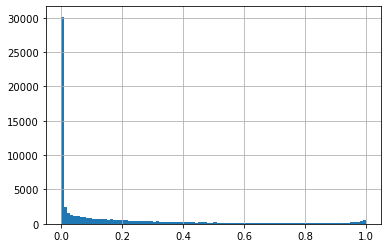

In [19]:
sub['toxic'] = eng1*0.5 + eng2*0.5
sub.toxic.hist(bins=100, log=False, alpha=1)

In [20]:
sub.to_csv('submission.csv', index=False)